In [1]:
# graph 문제를 풀기 위한 torch, compuet vision문제를 보다 쉽게 해결할 수 있는 모듈인 torchvision import
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose
import torch.nn.functional as F

In [2]:
def set_manual_seed(seed=42):
  """
    난수 발생시 고정된 난수를 발생시키기 위해 python local package
    random, numpy (다차원의 메트릭을 다루기위환 package), pytorch
    seed를 고정하는 function 입니다.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
set_manual_seed()

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', 
                   train=True, 
                   download=True,
                   transform=Compose([ToTensor()])),
                   batch_size=batch_size, 
                   shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', 
                   train=False, 
                   download=True,
                   transform=Compose([ToTensor()])),
                   batch_size=batch_size, 
                   shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
"""
    HyperParameters
"""
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

In [64]:
"""
    Operation:
    - Convoltuon 2D (width, height) 이미지의 특징을 보다 잘 찾아내기 위해
    - MaxPooling 2D (width, height) 잘 찾아진 특징을 풀링을 통해서 가장 큰 값만 얻어내기 위한 기법
    - ReLU (Activation function) 비선형 함수
    - Dropout (random drop out => features) 오버핏팅을 피하기 위한 기법
"""
class ConvoltuonNeuralNet(nn.Module):
    def __init__(self):
        super(ConvoltuonNeuralNet, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        # print(f'feature extraction size: {x.size()}')
        x = x.view(-1, 320)
        # print(f'transfrom size: {x.size()}')
        x = self.fully_connected(x)

        return x

model = ConvoltuonNeuralNet().to(device)
input_image = torch.rand((1, 1, 28, 28)).to(device)
y = model(input_image)

In [6]:
model = ConvoltuonNeuralNet().to(device)
# input_image = torch.rand((1, 1, 28, 28)).to(device)
# y = model(input_image)

In [7]:
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

In [8]:
loss_bucket = []
def train_op(model, device, train_loader, optim, epoch):
    model.train()
    for batch_idx, (input_train_images, input_train_labels) in enumerate(train_loader):
        input_train_images, input_train_labels = input_train_images.to(device), input_train_labels.to(device)

        optim.zero_grad()
        """
          y: 부추라고 생각해
        """
        y = model(input_train_images)
        """
            정답과 예측한 값을 비교한뒤 맞으면 0 틀리면 1
        """
        loss = F.nll_loss(y.log(), input_train_labels)
        """
            결과를 다시 전달해준다
        """
        loss.backward()
        optim.step()
        loss_bucket.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Convoltuion Training Loss: {loss.item():.4f}')
            

def test_op(model, device, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for input_test_images, input_test_labels in test_loader:
            input_test_images, input_test_labels = input_test_images.to(device), input_test_labels.to(device)
            output = model(input_test_images)
            test_loss += F.nll_loss(output.log(), input_test_labels).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(input_test_labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = (correct / len(test_loader.dataset)) * 100
    print(f'convoltuion test loss: {test_loss}, acc: {accuracy}')

In [9]:
for epoch in range(num_epochs):
    train_op(model=model, device=device, train_loader=train_loader, optim=optim, epoch=epoch)
    test_op(model=model, device=device, test_loader=test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Convoltuion Training Loss: 2.3002
Convoltuion Training Loss: 2.1396
Convoltuion Training Loss: 1.3907
Convoltuion Training Loss: 1.2006
Convoltuion Training Loss: 1.1008
convoltuion test loss: 0.008568939965963364, acc: 65.25
Convoltuion Training Loss: 0.9529
Convoltuion Training Loss: 1.1703
Convoltuion Training Loss: 1.0345
Convoltuion Training Loss: 0.8594
Convoltuion Training Loss: 0.9255
convoltuion test loss: 0.0069798463821411135, acc: 71.64
Convoltuion Training Loss: 0.9180
Convoltuion Training Loss: 0.7463
Convoltuion Training Loss: 0.9590
Convoltuion Training Loss: 0.8864
Convoltuion Training Loss: 0.7380
convoltuion test loss: 0.006658867311477661, acc: 72.03
Convoltuion Training Loss: 0.9188
Convoltuion Training Loss: 0.6763
Convoltuion Training Loss: 0.8564
Convoltuion Training Loss: 0.6723
Convoltuion Training Loss: 0.6667
convoltuion test loss: 0.006188477528095245, acc: 73.92
Convoltuion Training Loss: 0.6887
Convoltuion Training Loss: 0.6750
Convoltuion Training Loss: 

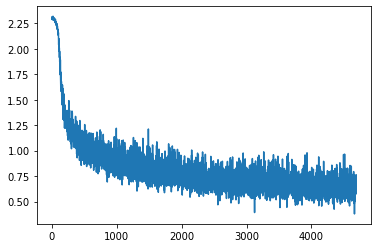

In [100]:
import matplotlib.pyplot as plt
plt.plot(loss_bucket)

예측된 값: 9
정답: 7


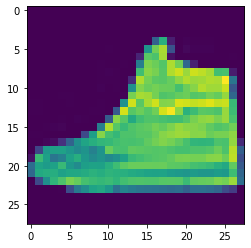

In [101]:
input_test_images ,input_test_labesl = next(iter(test_loader))
model.eval()
figure = plt.figure(figsize=(4, 4))
with torch.no_grad():
    y = model(input_test_images.to(device))
    print(f'예측된 값: {torch.argmax(y[0]).detach().cpu().numpy()}')
    print(f'정답: {input_test_labesl[0].detach().cpu().numpy()}')
    plt.imshow(input_test_images[0].squeeze())


In [66]:
! pip install shap

     |████████████████████████████████| 356 kB 4.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491650 sha256=d99e580a26b9a416815b59c44a8596238b97cb4101632b79f277567de50694cf
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [67]:
import shap

In [70]:
image_batchs = next(iter(test_loader))

In [71]:
input_images, input_labels = image_batchs

In [93]:
render_bg = input_images[:100].to(device)
test_images = input_images[0:2].to(device)  # 10개의 이미가 리스트에 담긴다.
explan = shap.DeepExplainer(model, render_bg)

In [94]:
extraction_shap_value = explan.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


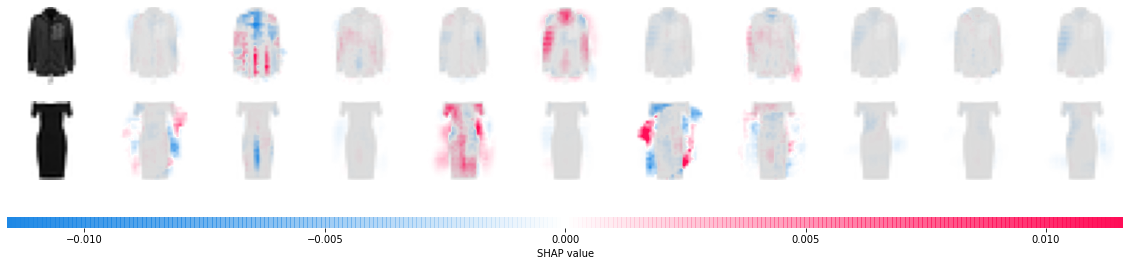

예측된 값: 4
정답: 4


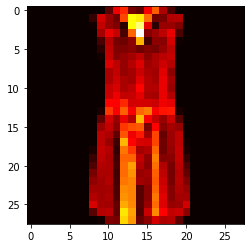

In [98]:
shape_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in extraction_shap_value]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shape_numpy, -test_numpy)

with torch.no_grad():
    y = model(test_images.to(device))
    print(f'예측된 값: {torch.argmax(y[0]).detach().cpu().numpy()}')
    print(f'정답: {input_labels[0].detach().cpu().numpy()}')
    plt.imshow(input_test_images[0].squeeze(), cmap='hot')